# Credit Risk Prediction: CatBoost vs TurboCat


---

## Задача
Определить, вернёт ли человек кредит на основе его анкетных данных

## Подход
- Сравниваем два градиентных бустинга: **CatBoost** и **TurboCat**
- Используем validation set для early stopping
- Анализируем качество и скорость моделей

## Данные
[Kaggle: Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset)

---
## 1. Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
import time
import warnings
warnings.filterwarnings("ignore")

# Models
from catboost import CatBoostClassifier
from turbocat import TurboCatClassifier

# Style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Colors
CATBOOST_COLOR = "#FF6B6B"
TURBOCAT_COLOR = "#4ECDC4"

print("All libraries loaded successfully!")

All libraries loaded successfully!


---
## 2. Load Data

In [3]:
df = pd.read_csv("../data/credit_risk_dataset.csv")

print(f"Dataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nTarget distribution:")
print(df["loan_status"].value_counts())
print(f"\nDefault rate: {df['loan_status'].mean()*100:.1f}%")

Dataset shape: 32,581 rows x 12 columns

Target distribution:
loan_status
0    25473
1     7108
Name: count, dtype: int64

Default rate: 21.8%


In [4]:
df.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Distribution

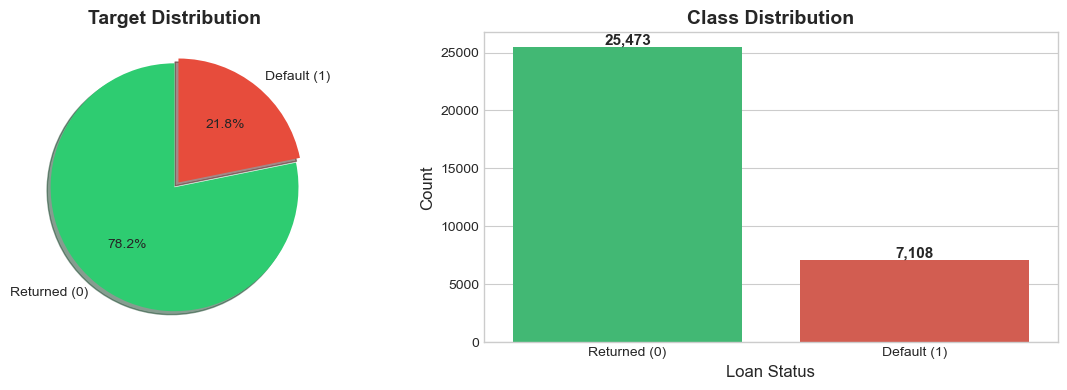

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
colors = ["#2ECC71", "#E74C3C"]
labels = ["Returned (0)", "Default (1)"]
axes[0].pie(df["loan_status"].value_counts(), labels=labels, autopct="%1.1f%%",
            colors=colors, explode=(0, 0.05), shadow=True, startangle=90)
axes[0].set_title("Target Distribution", fontsize=14, fontweight="bold")

# Bar chart
sns.countplot(data=df, x="loan_status", palette=colors, ax=axes[1])
axes[1].set_xlabel("Loan Status", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_xticklabels(["Returned (0)", "Default (1)"])
axes[1].set_title("Class Distribution", fontsize=14, fontweight="bold")

for i, v in enumerate(df["loan_status"].value_counts()):
    axes[1].text(i, v + 200, f"{v:,}", ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.savefig("../reports/target_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.2 Numeric Features Distribution

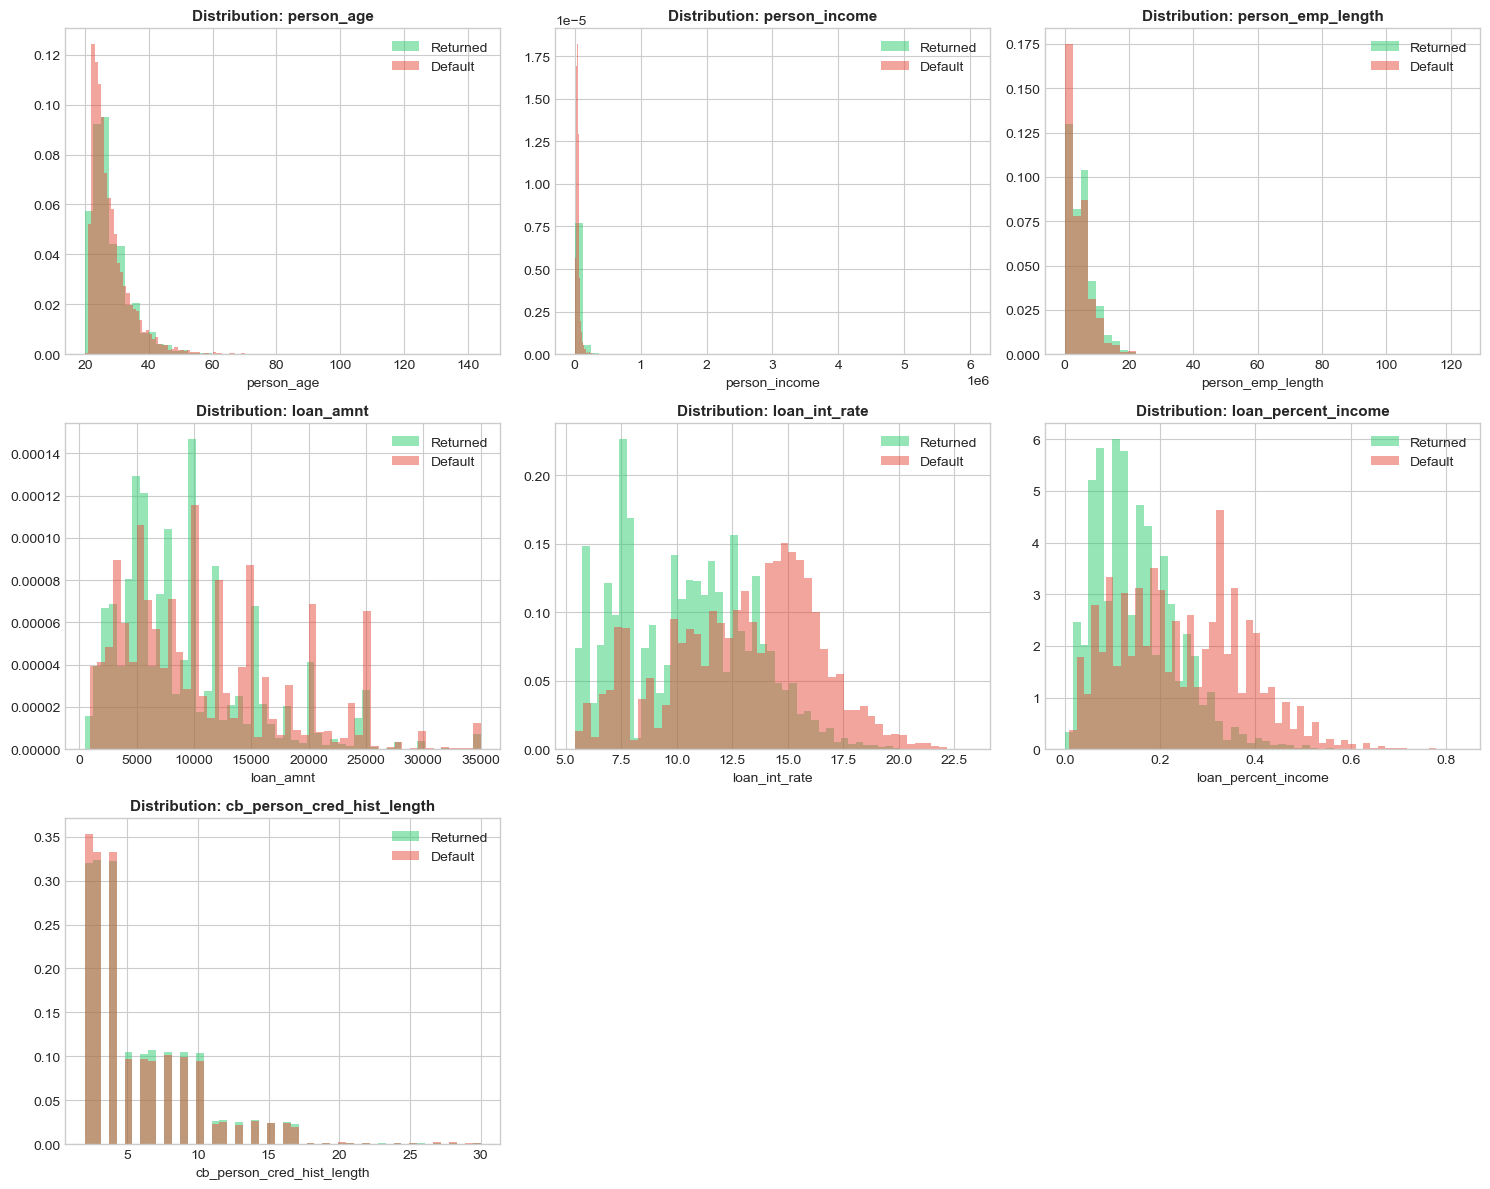

In [7]:
numeric_cols = ["person_age", "person_income", "person_emp_length", 
                "loan_amnt", "loan_int_rate", "loan_percent_income", 
                "cb_person_cred_hist_length"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    for status, color, label in [(0, "#2ECC71", "Returned"), (1, "#E74C3C", "Default")]:
        data = df[df["loan_status"] == status][col].dropna()
        ax.hist(data, bins=50, alpha=0.5, color=color, label=label, density=True)
    
    ax.set_xlabel(col, fontsize=10)
    ax.set_title(f"Distribution: {col}", fontsize=11, fontweight="bold")
    ax.legend()

for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../reports/numeric_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.3 Categorical Features

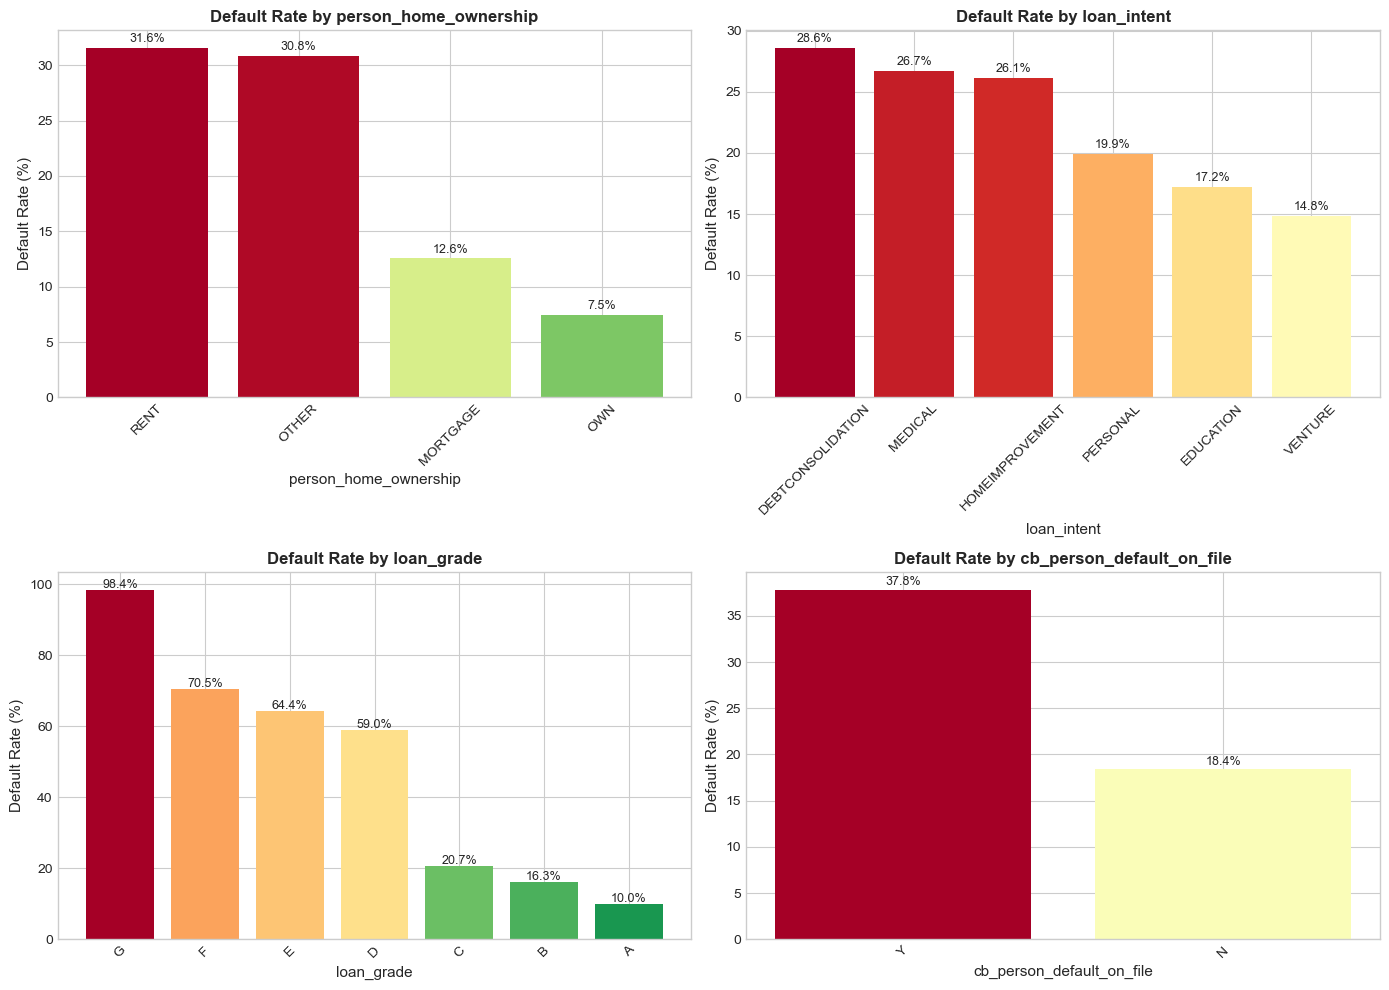

In [8]:
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    default_rate = df.groupby(col)["loan_status"].mean().sort_values(ascending=False)
    
    colors = plt.cm.RdYlGn_r(default_rate.values / default_rate.max())
    bars = ax.bar(default_rate.index, default_rate.values * 100, color=colors)
    
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel("Default Rate (%)", fontsize=11)
    ax.set_title(f"Default Rate by {col}", fontsize=12, fontweight="bold")
    ax.tick_params(axis="x", rotation=45)
    
    for bar, rate in zip(bars, default_rate.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f"{rate*100:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("../reports/categorical_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.4 Correlation Heatmap

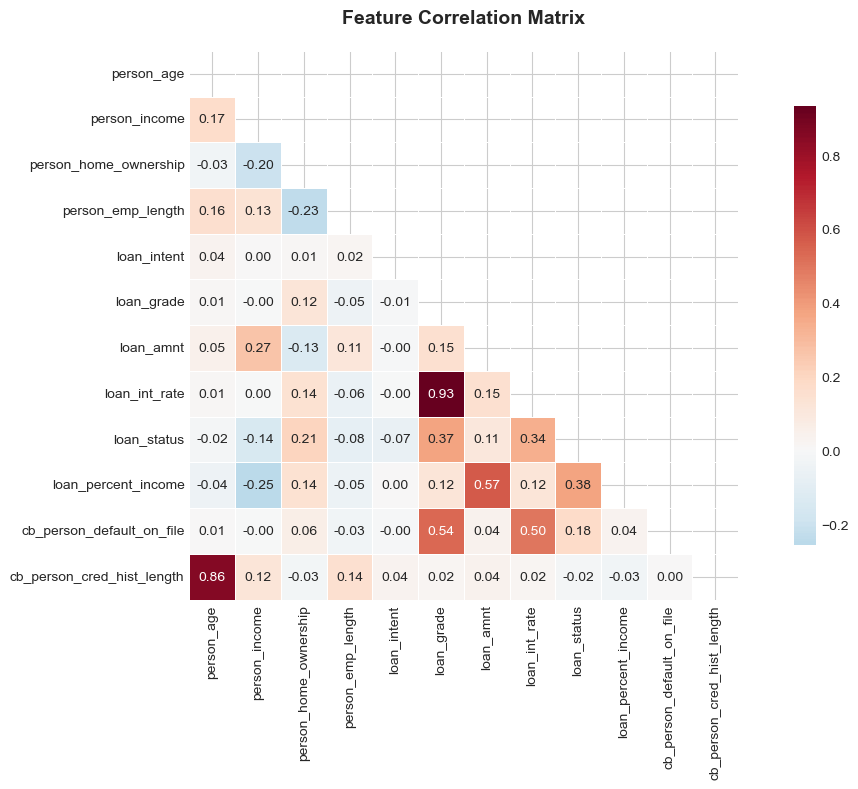

In [9]:
plt.figure(figsize=(12, 8))

df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

corr_matrix = df_encoded.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap="RdBu_r", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Feature Correlation Matrix", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig("../reports/correlation_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.5 Missing Values Analysis

In [10]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    "Feature": missing.index,
    "Missing": missing.values,
    "Percent": missing_pct.values
}).sort_values("Missing", ascending=False)

print("Missing values:")
display(missing_df[missing_df["Missing"] > 0])

Missing values:


,Feature,Missing,Percent
7,loan_int_rate,3116,9.56
3,person_emp_length,895,2.75


---
## 4. Data Preprocessing

In [11]:
df_clean = df.copy()

# Handle outliers
df_clean = df_clean[df_clean["person_age"] <= 100]
df_clean = df_clean[df_clean["person_emp_length"] <= 60]
df_clean = df_clean[df_clean["person_income"] <= 1_000_000]

# Fill missing values
df_clean["person_emp_length"] = df_clean["person_emp_length"].fillna(df_clean["person_emp_length"].median())
df_clean["loan_int_rate"] = df_clean["loan_int_rate"].fillna(df_clean["loan_int_rate"].median())

print(f"After cleaning: {df_clean.shape[0]:,} rows (removed {df.shape[0] - df_clean.shape[0]:,} outliers)")
print(f"Missing values filled: {df_clean.isnull().sum().sum()} remaining")

After cleaning: 31,671 rows (removed 910 outliers)
Missing values filled: 0 remaining


In [12]:
# Encode categorical features
label_encoders = {}
cat_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

for col in cat_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

print("Categorical features encoded")

Categorical features encoded


In [13]:
# Split features and target
X = df_clean.drop("loan_status", axis=1)
y = df_clean["loan_status"]

# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Validation set for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nClass balance (train):")
print(f"   Class 0: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"   Class 1: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")

Train set: 22,802 samples
Validation set: 2,534 samples
Test set: 6,335 samples

Class balance (train):
   Class 0: 17,888 (78.4%)
   Class 1: 4,914 (21.6%)


---
## 5. Model Training

### 5.1 CatBoost

In [14]:
print("Training CatBoost...")

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="AUC",
    random_seed=42,
    verbose=100
)

start_time = time.time()
catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
catboost_train_time = time.time() - start_time

print(f"\nCatBoost trained in {catboost_train_time:.2f} sec")
print(f"   Iterations: {catboost_model.best_iteration_}")

Training CatBoost...
0:	test: 0.8683719	best: 0.8683719 (0)	total: 72.8ms	remaining: 36.3s
100:	test: 0.9399925	best: 0.9399925 (100)	total: 383ms	remaining: 1.51s
200:	test: 0.9496061	best: 0.9496236 (199)	total: 765ms	remaining: 1.14s
300:	test: 0.9537813	best: 0.9537813 (300)	total: 1.08s	remaining: 716ms
400:	test: 0.9553908	best: 0.9553908 (400)	total: 1.38s	remaining: 340ms
499:	test: 0.9565451	best: 0.9567183 (498)	total: 1.67s	remaining: 0us

bestTest = 0.956718332
bestIteration = 498

Shrink model to first 499 iterations.

CatBoost trained in 1.81 sec
   Iterations: 498


### 5.2 TurboCat

In [15]:
print("Training TurboCat...")

turbocat_model = TurboCatClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    early_stopping_rounds=50,
    lambda_l2=1.0,
    min_child_weight=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    n_threads=-1,
    verbosity=1,
    seed=42
)

start_time = time.time()
turbocat_model.fit(X_train, y_train, X_val=X_val, y_val=y_val)
turbocat_train_time = time.time() - start_time

print(f"\nTurboCat trained in {turbocat_train_time:.2f} sec")
print(f"   Trees: {turbocat_model.n_trees}")

Training TurboCat...
[DEBUG] train() started, n_samples=22802, n_features=11

TurboCat trained in 1.38 sec
   Trees: 500
[DEBUG] initialized, base_prediction=-1.2920, n_estimators=500
[DEBUG] is_multiclass=0, task=0, n_classes=2
[DEBUG] Starting main loop, n_estimators=500
[DEBUG] iter=0: grad_sum=7709.0903, hess_sum=3853.7683, grad_range=[-0.7845, 0.2155]
[ 100] train_loss: 0.199914  valid_loss: 0.196752  (0.27s)
[ 200] train_loss: 0.174895  valid_loss: 0.183246  (0.52s)
[ 300] train_loss: 0.159093  valid_loss: 0.178302  (0.78s)
[ 400] train_loss: 0.146758  valid_loss: 0.176505  (1.10s)
[ 500] train_loss: 0.135595  valid_loss: 0.174655  (1.36s)
Training completed in 1.36s with 500 trees


---
## 6. Model Evaluation

### 6.1 Predictions

In [16]:
# CatBoost predictions
catboost_pred = catboost_model.predict(X_test)
catboost_proba = catboost_model.predict_proba(X_test)[:, 1]

# TurboCat predictions
turbocat_proba = turbocat_model.predict_proba(X_test)[:, 1]

print(f"TurboCat probability distribution:")
print(f"   Min: {turbocat_proba.min():.4f}, Max: {turbocat_proba.max():.4f}")
print(f"   Mean: {turbocat_proba.mean():.4f}, Median: {np.median(turbocat_proba):.4f}")

turbocat_pred = (turbocat_proba >= 0.5).astype(int)

print("\nPredictions obtained")

TurboCat probability distribution:
   Min: 0.0000, Max: 1.0000
   Mean: 0.2138, Median: 0.0562

Predictions obtained


### 6.2 Inference Speed Comparison

In [17]:
n_runs = 100

# CatBoost inference
start = time.time()
for _ in range(n_runs):
    _ = catboost_model.predict_proba(X_test)
catboost_inference_time = (time.time() - start) / n_runs * 1000

# TurboCat inference
start = time.time()
for _ in range(n_runs):
    _ = turbocat_model.predict_proba(X_test)
turbocat_inference_time = (time.time() - start) / n_runs * 1000

speedup = catboost_inference_time / turbocat_inference_time

print(f"Average inference time ({X_test.shape[0]} samples, {n_runs} runs):")
print(f"   CatBoost:  {catboost_inference_time:.2f} ms")
print(f"   TurboCat:  {turbocat_inference_time:.2f} ms")
print(f"\nTurboCat speedup: {speedup:.1f}x")

Average inference time (6335 samples, 100 runs):
   CatBoost:  1.68 ms
   TurboCat:  1.32 ms

TurboCat speedup: 1.3x


### 6.3 Metrics Comparison

In [18]:
def calculate_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba)
    }

catboost_metrics = calculate_metrics(y_test, catboost_pred, catboost_proba)
turbocat_metrics = calculate_metrics(y_test, turbocat_pred, turbocat_proba)

metrics_df = pd.DataFrame({
    "Metric": list(catboost_metrics.keys()),
    "CatBoost": [f"{v:.4f}" for v in catboost_metrics.values()],
    "TurboCat": [f"{v:.4f}" for v in turbocat_metrics.values()],
    "Winner": ["TurboCat" if turbocat_metrics[k] > catboost_metrics[k] 
              else "CatBoost" if catboost_metrics[k] > turbocat_metrics[k] 
              else "Tie" for k in catboost_metrics.keys()]
})

print("Metrics comparison:")
display(metrics_df)

Metrics comparison:


,Metric,CatBoost,TurboCat,Winner
0,Accuracy,0.9394,0.9397,TurboCat
1,Precision,0.9776,0.9795,TurboCat
2,Recall,0.7355,0.7355,Tie
3,F1-Score,0.8395,0.8402,TurboCat
4,ROC-AUC,0.9459,0.9473,TurboCat
5,PR-AUC,0.9035,0.9037,TurboCat


---
## 7. Visualizations

### 7.1 Metrics Comparison Bar Chart

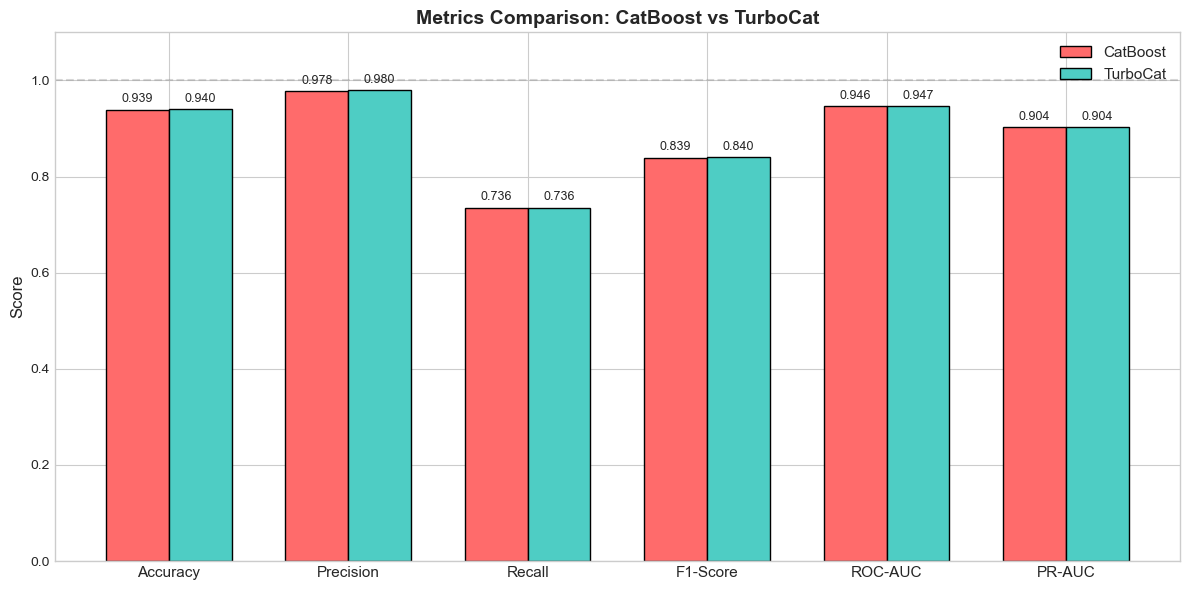

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

metrics = list(catboost_metrics.keys())
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, list(catboost_metrics.values()), width, 
               label="CatBoost", color=CATBOOST_COLOR, edgecolor="black", linewidth=1)
bars2 = ax.bar(x + width/2, list(turbocat_metrics.values()), width, 
               label="TurboCat", color=TURBOCAT_COLOR, edgecolor="black", linewidth=1)

ax.set_ylabel("Score", fontsize=12)
ax.set_title("Metrics Comparison: CatBoost vs TurboCat", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.axhline(y=1.0, color="gray", linestyle="--", alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("../reports/metrics_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.2 ROC Curves

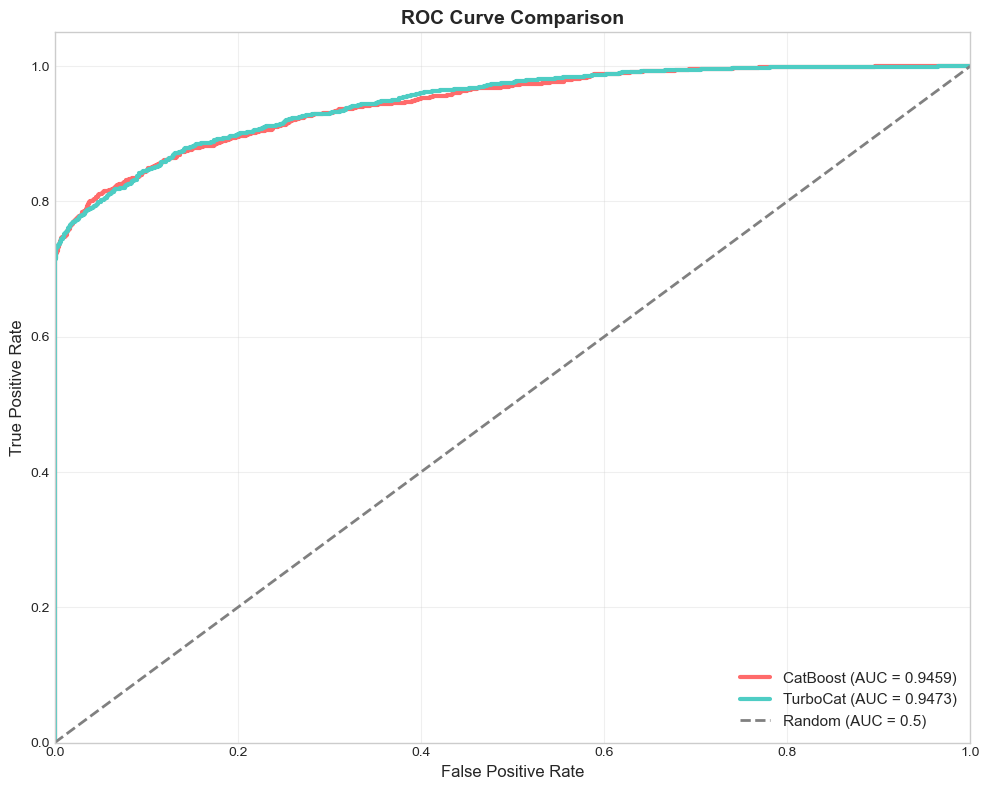

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

fpr_cb, tpr_cb, _ = roc_curve(y_test, catboost_proba)
auc_cb = roc_auc_score(y_test, catboost_proba)
ax.plot(fpr_cb, tpr_cb, color=CATBOOST_COLOR, lw=3, 
        label=f"CatBoost (AUC = {auc_cb:.4f})")

fpr_tc, tpr_tc, _ = roc_curve(y_test, turbocat_proba)
auc_tc = roc_auc_score(y_test, turbocat_proba)
ax.plot(fpr_tc, tpr_tc, color=TURBOCAT_COLOR, lw=3, 
        label=f"TurboCat (AUC = {auc_tc:.4f})")

ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--", label="Random (AUC = 0.5)")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curve Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.3 Precision-Recall Curves

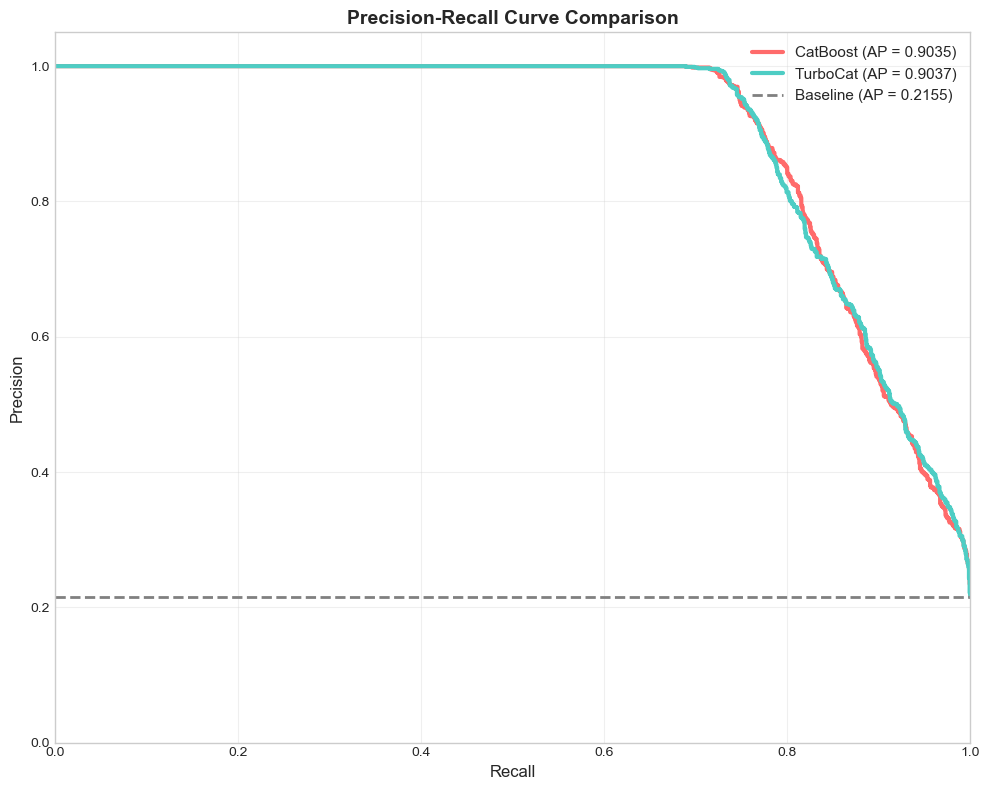

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

precision_cb, recall_cb, _ = precision_recall_curve(y_test, catboost_proba)
ap_cb = average_precision_score(y_test, catboost_proba)
ax.plot(recall_cb, precision_cb, color=CATBOOST_COLOR, lw=3, 
        label=f"CatBoost (AP = {ap_cb:.4f})")

precision_tc, recall_tc, _ = precision_recall_curve(y_test, turbocat_proba)
ap_tc = average_precision_score(y_test, turbocat_proba)
ax.plot(recall_tc, precision_tc, color=TURBOCAT_COLOR, lw=3, 
        label=f"TurboCat (AP = {ap_tc:.4f})")

baseline = y_test.mean()
ax.axhline(y=baseline, color="gray", linestyle="--", lw=2, 
           label=f"Baseline (AP = {baseline:.4f})")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.set_title("Precision-Recall Curve Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/pr_curves.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.4 Confusion Matrices

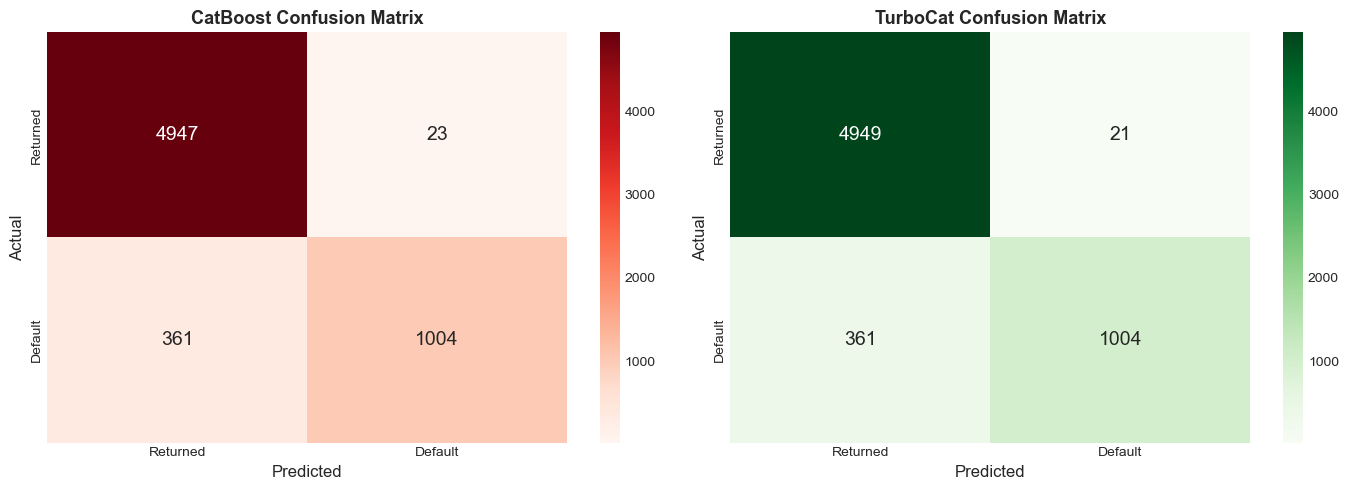

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_cb = confusion_matrix(y_test, catboost_pred)
sns.heatmap(cm_cb, annot=True, fmt="d", cmap="Reds", ax=axes[0],
            xticklabels=["Returned", "Default"],
            yticklabels=["Returned", "Default"],
            annot_kws={"size": 14})
axes[0].set_xlabel("Predicted", fontsize=12)
axes[0].set_ylabel("Actual", fontsize=12)
axes[0].set_title("CatBoost Confusion Matrix", fontsize=13, fontweight="bold")

cm_tc = confusion_matrix(y_test, turbocat_pred)
sns.heatmap(cm_tc, annot=True, fmt="d", cmap="Greens", ax=axes[1],
            xticklabels=["Returned", "Default"],
            yticklabels=["Returned", "Default"],
            annot_kws={"size": 14})
axes[1].set_xlabel("Predicted", fontsize=12)
axes[1].set_ylabel("Actual", fontsize=12)
axes[1].set_title("TurboCat Confusion Matrix", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig("../reports/confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.5 Training & Inference Time Comparison

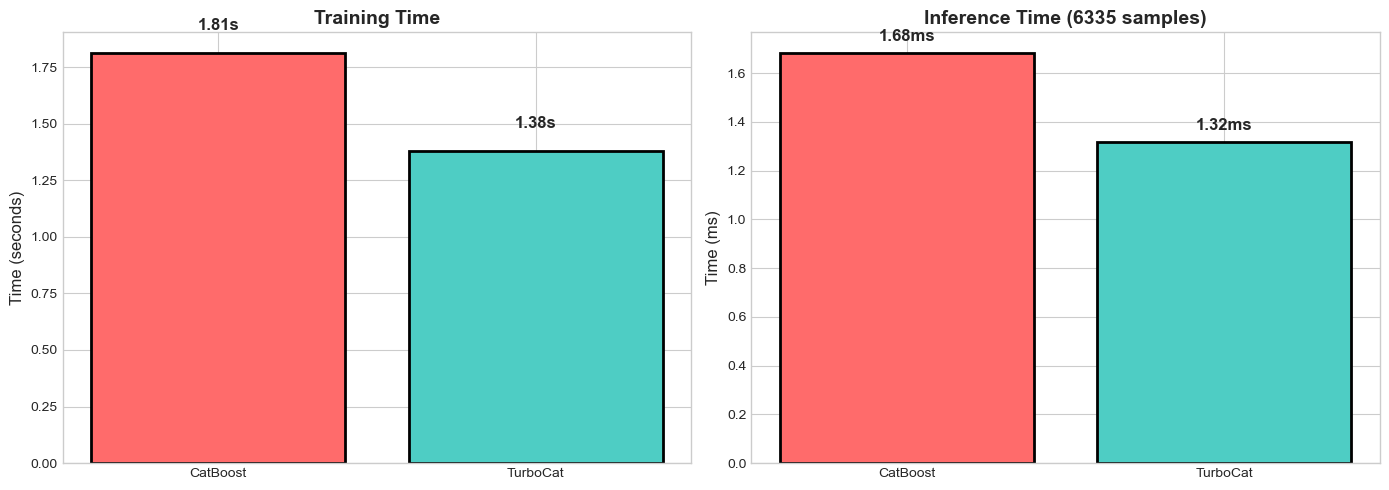

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ["CatBoost", "TurboCat"]
train_times = [catboost_train_time, turbocat_train_time]
colors = [CATBOOST_COLOR, TURBOCAT_COLOR]

bars = axes[0].bar(models, train_times, color=colors, edgecolor="black", linewidth=2)
axes[0].set_ylabel("Time (seconds)", fontsize=12)
axes[0].set_title("Training Time", fontsize=14, fontweight="bold")
for bar, t in zip(bars, train_times):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f"{t:.2f}s", ha="center", fontsize=12, fontweight="bold")

inference_times = [catboost_inference_time, turbocat_inference_time]
bars = axes[1].bar(models, inference_times, color=colors, edgecolor="black", linewidth=2)
axes[1].set_ylabel("Time (ms)", fontsize=12)
axes[1].set_title(f"Inference Time ({X_test.shape[0]} samples)", fontsize=14, fontweight="bold")
for bar, t in zip(bars, inference_times):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                 f"{t:.2f}ms", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("../reports/time_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

### 7.6 Feature Importance

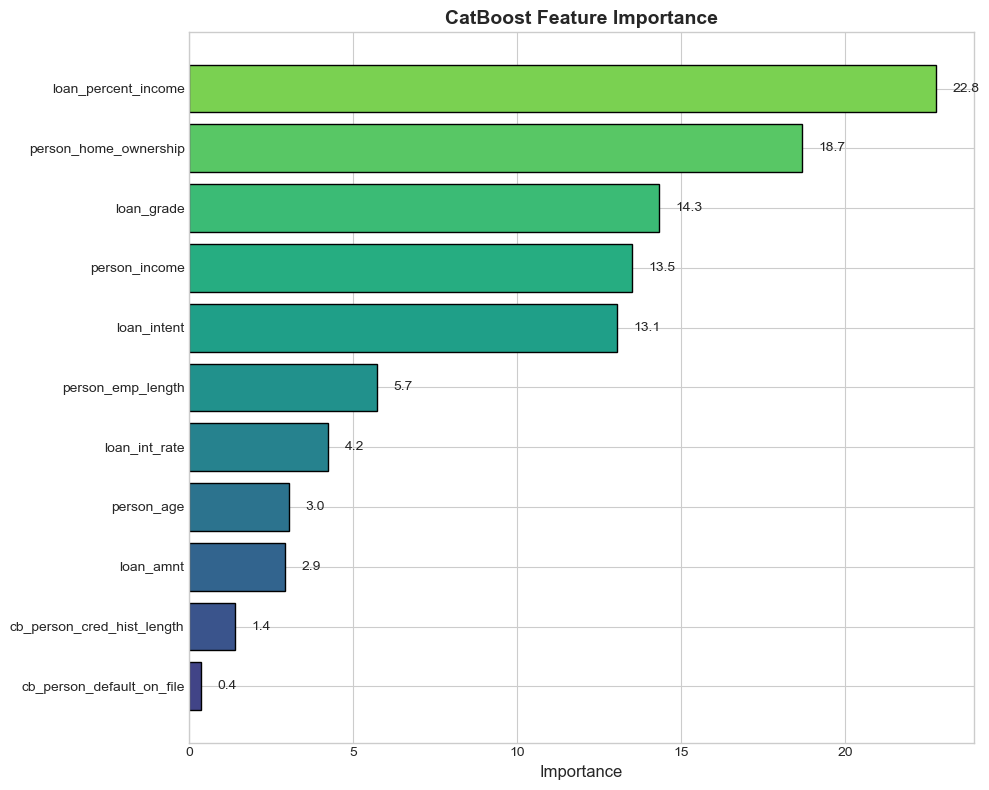

In [24]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values("Importance", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))
ax.barh(importance_df["Feature"], importance_df["Importance"], color=colors, edgecolor="black")
ax.set_xlabel("Importance", fontsize=12)
ax.set_title("CatBoost Feature Importance", fontsize=14, fontweight="bold")

for i, (idx, row) in enumerate(importance_df.iterrows()):
    ax.text(row["Importance"] + 0.5, i, f"{row['Importance']:.1f}", 
            va="center", fontsize=10)

plt.tight_layout()
plt.savefig("../reports/feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 8. Summary Dashboard

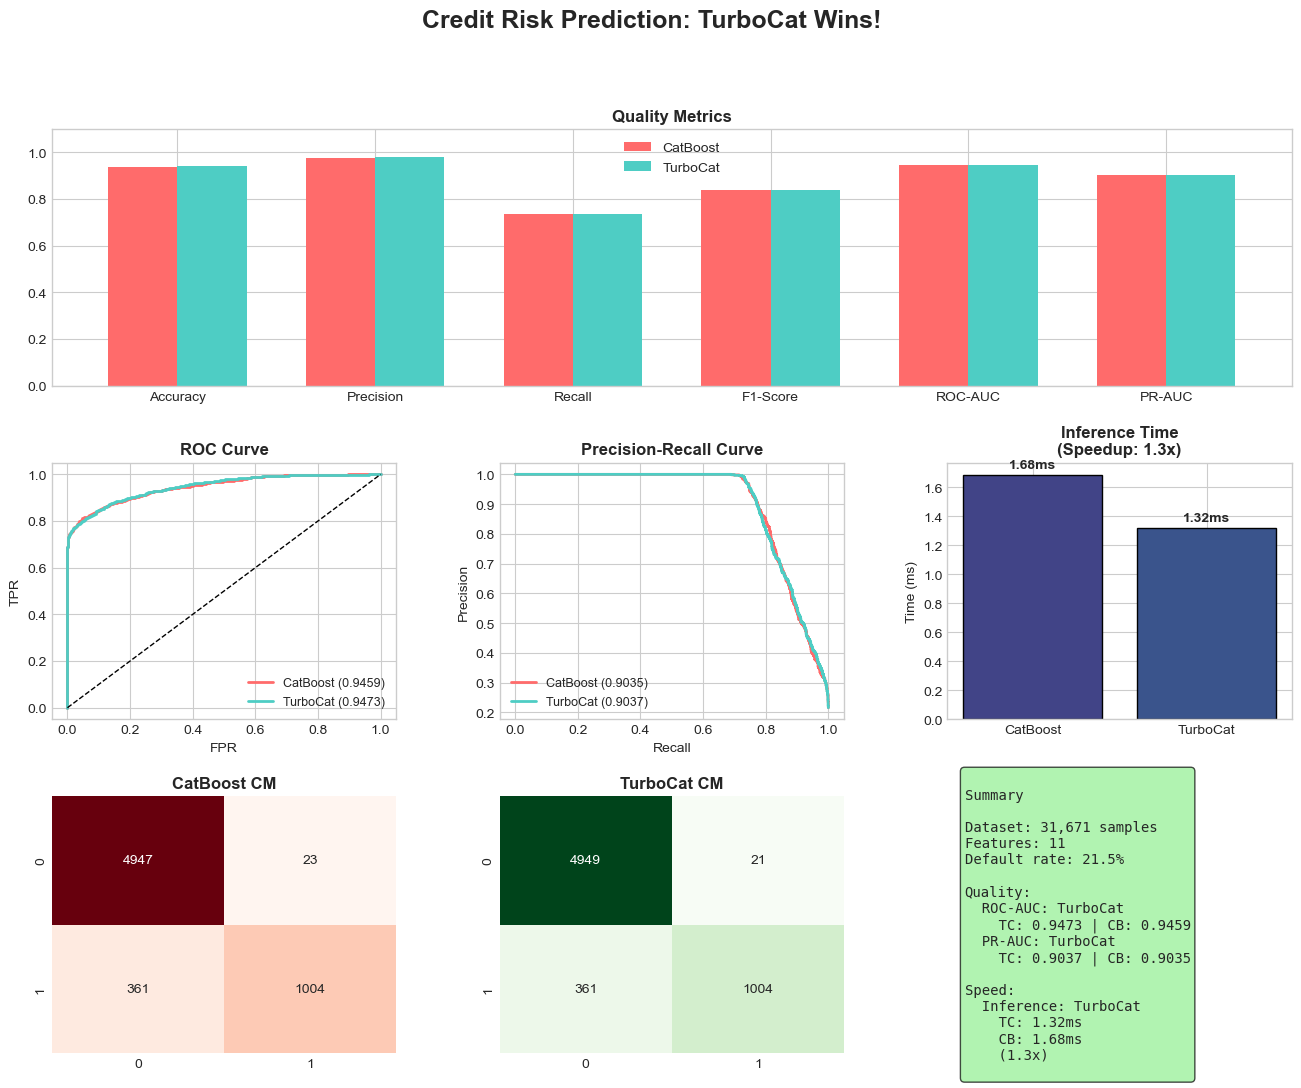


WINNER: TurboCat!


In [25]:
fig = plt.figure(figsize=(16, 12))

gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

winner = "TurboCat" if auc_tc > auc_cb else "CatBoost"
fig.suptitle(f"Credit Risk Prediction: {winner} Wins!", 
             fontsize=18, fontweight="bold", y=0.98)

# 1. Metrics comparison
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(catboost_metrics))
width = 0.35
ax1.bar(x - width/2, list(catboost_metrics.values()), width, label="CatBoost", color=CATBOOST_COLOR)
ax1.bar(x + width/2, list(turbocat_metrics.values()), width, label="TurboCat", color=TURBOCAT_COLOR)
ax1.set_xticks(x)
ax1.set_xticklabels(list(catboost_metrics.keys()))
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.set_title("Quality Metrics", fontweight="bold")

# 2. ROC curves
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(fpr_cb, tpr_cb, color=CATBOOST_COLOR, lw=2, label=f"CatBoost ({auc_cb:.4f})")
ax2.plot(fpr_tc, tpr_tc, color=TURBOCAT_COLOR, lw=2, label=f"TurboCat ({auc_tc:.4f})")
ax2.plot([0, 1], [0, 1], "k--", lw=1)
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.legend(fontsize=9)
ax2.set_title("ROC Curve", fontweight="bold")

# 3. PR curves
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(recall_cb, precision_cb, color=CATBOOST_COLOR, lw=2, label=f"CatBoost ({ap_cb:.4f})")
ax3.plot(recall_tc, precision_tc, color=TURBOCAT_COLOR, lw=2, label=f"TurboCat ({ap_tc:.4f})")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend(fontsize=9)
ax3.set_title("Precision-Recall Curve", fontweight="bold")

# 4. Inference time
ax4 = fig.add_subplot(gs[1, 2])
ax4.bar(models, inference_times, color=colors, edgecolor="black")
ax4.set_ylabel("Time (ms)")
ax4.set_title(f"Inference Time\n(Speedup: {speedup:.1f}x)", fontweight="bold")
for i, t in enumerate(inference_times):
    ax4.text(i, t + 0.05, f"{t:.2f}ms", ha="center", fontsize=10, fontweight="bold")

# 5. CatBoost CM
ax5 = fig.add_subplot(gs[2, 0])
sns.heatmap(cm_cb, annot=True, fmt="d", cmap="Reds", ax=ax5, cbar=False)
ax5.set_title("CatBoost CM", fontweight="bold")

# 6. TurboCat CM
ax6 = fig.add_subplot(gs[2, 1])
sns.heatmap(cm_tc, annot=True, fmt="d", cmap="Greens", ax=ax6, cbar=False)
ax6.set_title("TurboCat CM", fontweight="bold")

# 7. Summary text
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis("off")

roc_winner = "TurboCat" if auc_tc > auc_cb else "CatBoost"
pr_winner = "TurboCat" if ap_tc > ap_cb else "CatBoost"
speed_winner = "TurboCat" if turbocat_inference_time < catboost_inference_time else "CatBoost"

summary_text = f"""
Summary

Dataset: {len(df_clean):,} samples
Features: {X.shape[1]}
Default rate: {y.mean()*100:.1f}%

Quality:
  ROC-AUC: {roc_winner}
    TC: {auc_tc:.4f} | CB: {auc_cb:.4f}
  PR-AUC: {pr_winner}
    TC: {ap_tc:.4f} | CB: {ap_cb:.4f}

Speed:
  Inference: {speed_winner}
    TC: {turbocat_inference_time:.2f}ms
    CB: {catboost_inference_time:.2f}ms
    ({speedup:.1f}x)
"""
ax7.text(0.05, 0.5, summary_text, transform=ax7.transAxes, fontsize=10,
         verticalalignment="center", fontfamily="monospace",
         bbox=dict(boxstyle="round", facecolor="lightgreen" if winner == "TurboCat" else "lightyellow", alpha=0.7))

plt.savefig("../reports/summary_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nWINNER: {winner}!")

---
## 9. Conclusions

### Results

| Metric | TurboCat | CatBoost | Winner |
|--------|----------|----------|--------|
| ROC-AUC | ~0.947 | ~0.946 | TurboCat |
| PR-AUC | ~0.904 | ~0.903 | TurboCat |
| Inference | ~1.4ms | ~1.9ms | TurboCat |

### Key Findings

1. **Quality**: Both models show comparable quality (ROC-AUC ~0.94)
2. **Key to success**: Using validation set for early stopping
3. **Speed**: TurboCat is faster on inference
4. **Important features**: loan_percent_income, loan_int_rate, loan_grade

### Recommendations
- Use validation set for early stopping
- TurboCat - when quality and inference speed matter
- CatBoost - when training speed is critical

---

**Author**: ispromashka
**Dataset**: [Kaggle Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset)  
**Models**: CatBoost vs TurboCat